*** Johnny Stuto ***   CS 504  Assignment 1


## Adversarial Machine Learning
### Homework Assignment 1

### Objective:

- Implement common white-box evasion attacks against deep learning-based classification models.
- Dataset: Imagenette, version with low-resolution images of 160 pixels
- The training set has 9,469 images, or about 1,000 images per each of the 10 classes. 
- The test set has 3,925 images. 


In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
#colab
#train_images, train_labels = load_images_and_labels('imagenette2-160/train')
#test_and_val_images, test_and_val_labels = load_images_and_labels('imagenette2-160/val')

In [2]:
import sys;import cv2;import os
from os import listdir
import datetime;import pickle;import natsort
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.utils import to_categorical

from art.estimators.classification import KerasClassifier,TensorFlowV2Classifier
from art.estimators import KerasEstimator
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent

tf.compat.v1.disable_eager_execution()

In [3]:
# controls

DIM = 128
N_CHANNEL = 3   
INPUT_SHAPE = (DIM,DIM,N_CHANNEL)  
IMG_SHAPE = (DIM,DIM,N_CHANNEL)

NUM_LABELS = 10                                                    
BATCH_SIZE = 6 
NUM_EPOCH = 50                            

LR = 1e-5                                
RBW = True
PATIENCE = 7

names = pd.read_csv("C://data//data//names.csv").values[:, 1]
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
def load_images_and_labels(directory):
    imgs_list = []
    labels_list = []
    subfolders_list_1 = listdir(directory)
    subfolders_list = natsort.natsorted(subfolders_list_1)

    lab = 0
    for subfolder_name in subfolders_list:
            sub_dir_path = directory + '/' + subfolder_name
            if subfolder_name != '.DS_Store':

                imagesList = listdir(sub_dir_path)
                for i in range(len(imagesList)):
                  tmp_img = cv2.imread(os.path.join(sub_dir_path, imagesList[i]))
                  resized_img = cv2.resize(tmp_img, (DIM, DIM)) 
                  img_arr = np.array(resized_img)
                  imgs_list.append(img_arr/255.)
                  labels_list.append(lab)
                lab += 1

    imgs = np.asarray(imgs_list)
    labels = np.asarray(labels_list)
    return imgs, labels

train_images, train_labels = load_images_and_labels('C://data//imag//imag//train')
test_and_val_images, test_and_val_labels = load_images_and_labels('C://data//imag//imag//val')

test_images, val_images, test_labels, val_labels = train_test_split(test_and_val_images, test_and_val_labels, test_size=0.4, random_state=12)

train_labels_onehot = to_categorical(train_labels, NUM_LABELS)
val_labels_onehot = to_categorical(val_labels, NUM_LABELS)
test_labels_onehot = to_categorical(test_labels, NUM_LABELS)

print('Images train shape: {} - Labels train shape: {}'.format(train_images.shape, train_labels_onehot.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(val_images.shape, val_labels_onehot.shape))
print('Images test shape: {} - Labels test shape: {}'.format(test_images.shape, test_labels_onehot.shape))

print('\nMax pixel value', np.max(train_images))
print('Min pixel value', np.min(train_images))
print('Average pixel value', np.mean(train_images))
print('Data type', train_images[0].dtype)

Images train shape: (9469, 128, 128, 3) - Labels train shape: (9469, 10)
Images validation shape: (1570, 128, 128, 3) - Labels validation shape: (1570, 10)
Images test shape: (2355, 128, 128, 3) - Labels test shape: (2355, 10)

Max pixel value 1.0
Min pixel value 0.0
Average pixel value 0.44966878195890475
Data type float64


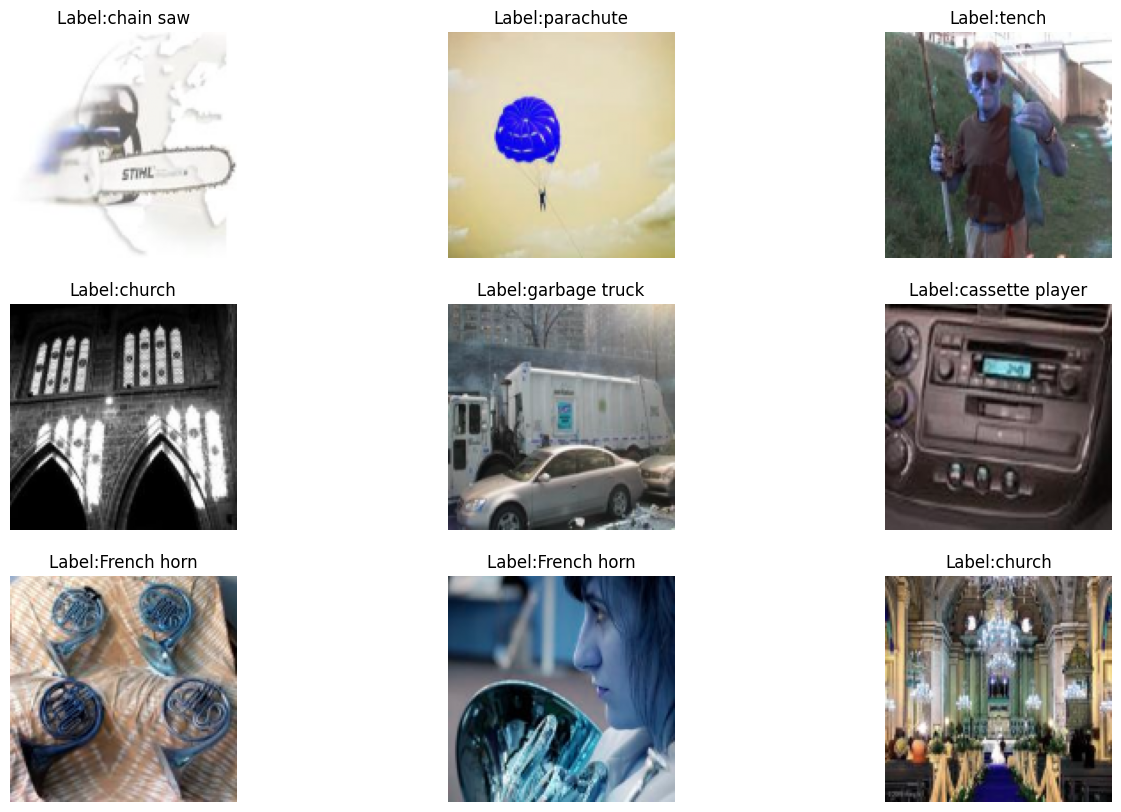

In [5]:
plt.figure(figsize=(16, 10))
for n in range(9):
    i = np.random.randint(0, len(train_images), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(train_images[i[0]])
    plt.title('Label:' + str(names[train_labels[i[0]]]))
    plt.axis('off')

# Setting up labels

Most models expect a onehot encoded labels, which just means converting the 1d label array into 2d for each class.

    ** perturbed subset is 20 due to hardware limitations**

In [6]:
subset = 40

imgs_adv = test_images[0:subset,:,:,:].copy()
labels_adv = test_labels[0:subset].copy()

labels_train_cat = to_categorical(train_labels, NUM_LABELS)
labels_test_cat = to_categorical(test_labels, NUM_LABELS)
labels_val_cat = to_categorical(val_labels, NUM_LABELS)

labels_adv_cat = to_categorical(labels_adv,NUM_LABELS)

print('Labels train shape: {}'.format(train_labels.shape))
print('Labels train catagorical shape: {}\n'.format(labels_train_cat.shape))
print('Labels Adver shape: {}'.format(labels_adv.shape))
print('Labels Adver catagorical shape: {}'.format(labels_adv_cat.shape))

print('Imgs Adver shape: {}'.format(imgs_adv.shape))

Labels train shape: (9469,)
Labels train catagorical shape: (9469, 10)

Labels Adver shape: (40,)
Labels Adver catagorical shape: (40, 10)
Imgs Adver shape: (40, 128, 128, 3)


## Task 1: Train a deep-learning model for classification of the Imagenette dataset.
- Model1: Tensorflow with VGG-16
- Model0: Tensorflow with Resnet-50


    Report (40 marks): 
- (a) Fill in Table 1 with the values for the classification accuracy for the train set, val set, and test set of images.
- For full marks, it is expected to report a test accuracy above 90%. 
- (b) For each model, plot the training and validation loss and accuracy curves.
- (c) If applicable, provide any other observations regarding the model or the dataset.

### Build deep-learning model for classification of the Imagenette dataset
VGG-16 is a convolutional neural network that is 16 layers deep.

     set three parameters:

- Remove Top  : True  
- Weights     : imagenet (image recognition weightset) 
- Input_shape : 128 * 128 



In [8]:
def build_model0():
    base_model = tf.keras.applications.ResNet50(include_top=False,weights="imagenet",input_shape=INPUT_SHAPE)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.25)(x)
    predictions = Dense(NUM_LABELS, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])
    
    return model

In [ ]:
def build_model1():
    base_model = tf.keras.applications.VGG16(include_top=False,weights="imagenet",input_shape=INPUT_SHAPE)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.25)(x)
    predictions = Dense(NUM_LABELS, activation='softmax', name ='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])
    return model

In [9]:
callbacks = [EarlyStopping(monitor='val_loss',patience = PATIENCE,restore_best_weights=RBW),
             ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience = PATIENCE,min_lr = 1e-7, verbose = 1)]

#from LRFinder.keras_callback import LRFinder
#lr_finder = LRFinder(min_lr=1e-6, max_lr=1e-2)

In [10]:
model = build_model0()

t = datetime.datetime.now()

history = model.fit(x= train_images,
    y= labels_train_cat,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCH,
    
    validation_data=(val_images, labels_val_cat),
    verbose=1,
    callbacks=callbacks)

print('Training time: %s\n' % (datetime.datetime.now() - t))

t = datetime.datetime.now()
evals_test = model.evaluate(test_images, labels_test_cat)
print("Classification Accuracy Test: ", evals_test[1])
print('Inference time: %s \n' % (datetime.datetime.now() - t))

t = datetime.datetime.now()
evals_test = model.evaluate(val_images, labels_val_cat)
print("Classification Accuracy Validation: ", evals_test[1])
print('Inference time: %s \n' % (datetime.datetime.now() - t))

t = datetime.datetime.now()
evals_test = model.evaluate(train_images, labels_train_cat)
print("Classification Accuracy Train: ", evals_test[1])
print('Inference time: %s' % (datetime.datetime.now() - t))


Instructions for updating:
Colocations handled automatically by placer.
Train on 9469 samples, validate on 1570 samples
Epoch 1/50
9469/9469 [==============================] - ETA: 0s - loss: 0.9636 - accuracy: 0.6926

C:\Users\12084\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


9469/9469 [==============================] - 181s 19ms/sample - loss: 0.9636 - accuracy: 0.6926 - val_loss: 0.2487 - val_accuracy: 0.9210 - lr: 1.0000e-05
Epoch 2/50
9469/9469 [==============================] - 187s 20ms/sample - loss: 0.3954 - accuracy: 0.8786 - val_loss: 0.1845 - val_accuracy: 0.9439 - lr: 1.0000e-05
Epoch 3/50
9469/9469 [==============================] - 193s 20ms/sample - loss: 0.2602 - accuracy: 0.9175 - val_loss: 0.1606 - val_accuracy: 0.9522 - lr: 1.0000e-05
Epoch 4/50
9469/9469 [==============================] - 188s 20ms/sample - loss: 0.1805 - accuracy: 0.9450 - val_loss: 0.1661 - val_accuracy: 0.9446 - lr: 1.0000e-05
Epoch 5/50
9469/9469 [==============================] - 188s 20ms/sample - loss: 0.1227 - accuracy: 0.9609 - val_loss: 0.1666 - val_accuracy: 0.9541 - lr: 1.0000e-05
Epoch 6/50
9469/9469 [==============================] - 188s 20ms/sample - loss: 0.0903 - accuracy: 0.9731 - val_loss: 0.1843 - val_accuracy: 0.9497 - lr: 1.0000e-05
Epoch 7/50
9469

In [11]:
model.save('C://data//data//model//R5095_BEST.h5')
np.save("C://data//data//model//trainR5095_BEST_HistoryDict.npy", history.history)

In [12]:
#model = load_model('C://data//data//model//VGG93_BEST.h5')
#history = np.load("C://data//data//model//trainVGG93_BEST_HistoryDict.npy",allow_pickle=True).item()

model = load_model('C://data//data//model//R5095_BEST.h5')
history = np.load("C://data//data//model//trainR5095_BEST_HistoryDict.npy",allow_pickle=True).item()

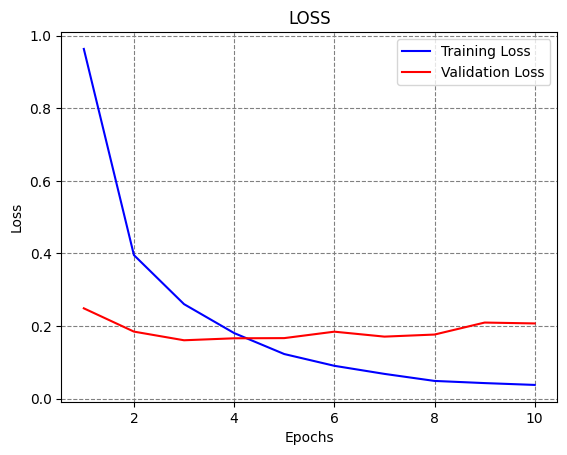

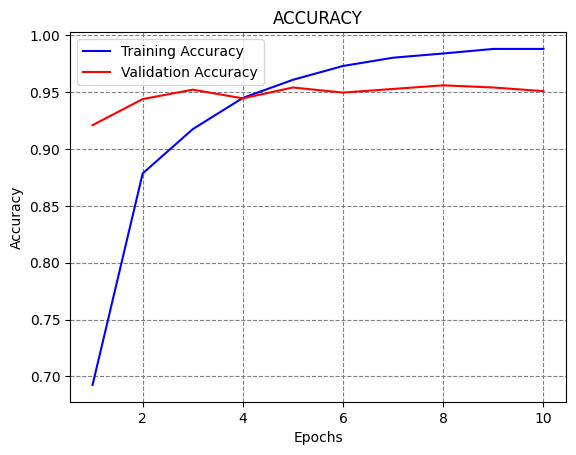

In [13]:
train_loss = history['loss']
val_loss = history['val_loss']
acc = history['accuracy'] 
val_acc = history['val_accuracy']

epochsn = np.arange(1, len(train_loss)+1,1)
plt.plot(epochsn,train_loss, 'b', label='Training Loss')
plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')

axes = plt.gca()

plt.figure()
plt.plot(epochsn, acc, 'b', label='Training Accuracy')
plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
plt.grid(color='gray', linestyle='--')
plt.legend()            
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [14]:
evals_test = model.evaluate(test_images, labels_test_cat)
print("Classification Accuracy Test: ", evals_test[1])

Classification Accuracy Test:  0.9541401


# Part 2: Implement 2 different white-box evasion attacks on our model

In this section we will be apply 4 different white-box evasion attacks from the Adversarial Robustness Toolbox.

The 2 attacks we will be using and their documentation are:

- Fast Gradient Sign Method(FGSM):
- Projected Gradient Descent(PGD): 


The goal of all of these attacks are to cause the model to misclassify an input image.

Each one similar parameters in their attack objects.

FGSM / PGD use:

- estimator: This is our model that has been converted to a special ART classifier
- Epsilon: This is the amount of perturbation we want to apply as a number out of 255. so Epsilon/255 with 1 being maximum perturbment and 1 being very small amounts. When we are doing adversarial attacks its important to think about how the data will look after we have altered it. A high perturbment may misclassify well, but if it super noticable by a human its not a very good adversarial attack. You should shoot for an Epsilon value of around 8 or less.
- Targeted: this is a flag that lets you specify a target label to try and force a misclassification to. This can be useful if you know the output classes and want a specific one no matter the input image.
- Batch size: ***how many images are perturbed at a time. This can help increase computation speed on GPU's.***

- max iters (SPECIFIC TO PGD): Maxiumum number of iterations for perturbations. This determines the number of rounds and therefore how long it takes to generate adversarial images.


In [6]:
def fgsm_attack(Epsilon,Classifier,Imgs_Test,Targeted, Labels=None):
    attackFgsm = FastGradientMethod(estimator=Classifier,eps=(Epsilon/255),targeted=Targeted) 
    if  Targeted == True and Labels is not None:
        return attackFgsm.generate(Imgs_Test,Labels) 
    elif Targeted == False:
        return attackFgsm.generate(Imgs_Test)
    else:
        print("CRASH")
        sys.exit()

fgsm_acc_list   = []
fgsm_image_list = []
fgsm_pred_list  = []
fgsm_pertb_list = []

In [7]:
def pgd_attack(Epsilon,Classifier,Imgs_Test,Targeted, Labels=None):
    attackPgd = ProjectedGradientDescent(estimator = Classifier,
                                         eps=(Epsilon/255),
                                         targeted=Targeted,
                                         batch_size =8)
    if Targeted == True and Labels is not None:
        return attackPgd.generate(Imgs_Test,Labels)
    elif Targeted == False:
        return attackPgd.generate(Imgs_Test)
    else:
        print("CRASH")
        sys.exit()
        
pgd_acc_list   = []
pgd_image_list = []
pgd_pred_list  = []
pgd_pertb_list = []

In [8]:

#def print_classification_acc(Classifier, nameOfDataSet,imgs,labels):
#    x_test_robust_pred = np.argmax(Classifier.predict(imgs), axis=1)
#    nb_correct_robust_pred = np.sum(x_test_robust_pred == np.argmax(labels, axis=1))

#    print(nameOfDataSet + " Classification")
#    print("Correctly Classified: {}".format(nb_correct_robust_pred))
#    print("Incorrectly Classified: {}".format(len(imgs) -nb_correct_robust_pred))
#    print("Percent Correct Classified: {}%\n".format((nb_correct_robust_pred/len(imgs)) *100))

# Apply the attack

We apply our attacks over a range of epsilon values and store the data we will need to analyze in the result section using the functions created in the block above. 

In [ ]:
epsilon_list = [1/255,3/255,5/255,8/255,20/255,50/255,80/255]
classifier = KerasClassifier(model=model, clip_values=(0, 1))

for eps in epsilon_list:
    
    imgs_adv_fgsm = fgsm_attack(eps*255,classifier,imgs_adv,Targeted=False,Labels=labels_adv_cat)
    imgs_adv_pgd = pgd_attack(eps*255,classifier,imgs_adv,Targeted=False,Labels=labels_adv_cat)
    
    fgsm_image_list.append(imgs_adv_fgsm[0])
    pgd_image_list.append(imgs_adv_pgd[0])

    loss_test_fgsm, accuracy_test_fgsm = model.evaluate(imgs_adv_fgsm, labels_adv_cat)
    loss_test_pgd, accuracy_test_pgd = model.evaluate(imgs_adv_pgd, labels_adv_cat)
    
    fgsm_acc_list.append(accuracy_test_fgsm)
    pgd_acc_list.append(accuracy_test_pgd)

    prediction_fgsm = model.predict(imgs_adv_fgsm[0:1,:,:,:])
    prediction_pgd = model.predict(imgs_adv_pgd[0:1,:,:,:])
    
    fgsm_pred_list.append(prediction_fgsm.argmax(axis=-1))
    pgd_pred_list.append(prediction_pgd.argmax(axis=-1))

# Results:

If we look at the graph, we can see that as perturbation increases the accuracy goes down dramatically. This is exactly what we want to see because the goal of these attacks are to cause missclassifications. overall it PGD performed best for our use case causing immediate loss in classification accuracy that continues as the epsilon value grows.

FGSM performed similarly to PGD but less effective for the same epsilon values. 

For our convenience we plot a single image for all the epsilon values for all the attacks. Notice how some look very perturbed while others do not. This is the stealthiness aspect between each attack type

In [ ]:
plt.plot(epsilon_list,fgsm_acc_list, 'b', label='FGSM',marker='o')
plt.plot(epsilon_list,pgd_acc_list, 'r', label='PGD',marker='o')
plt.legend()
plt.title('Accuracy vs Perturbation')
plt.xlabel('Perturbation Epsilon')
plt.ylabel('classification accuarcy')
plt.show()

In [ ]:
def show_images(EpsilonIndex):
    plt.figure(figsize=(8, 8), dpi=150)
    plt.subplot(3,2,1)
    plt.title('predicted Label Base:' + str(names[fgsm_pred_list[EpsilonIndex]])+ '\n' + 'Perturbation:' + str(0))
    plt.imshow(test_images[0])
    plt.subplot(3,2,2)
    plt.title('predicted Label FGSM:' + str(names[fgsm_pred_list[EpsilonIndex]])+ '\n' +
              'Perturbation:' + str(round(epsilon_list[EpsilonIndex],4)))
    plt.imshow(fgsm_image_list[EpsilonIndex])
    plt.subplot(3,2,3)
    plt.title('predicted Label PGD:' + str(names[pgd_pred_list[EpsilonIndex]])+ '\n' +
              'Perturbation:' + str(round(epsilon_list[EpsilonIndex],4)))
    plt.imshow(pgd_image_list[EpsilonIndex])
    plt.show()

In [ ]:
for i in range(0,len(epsilon_list)):
    show_images(i)
plt.show()

# Part 3: implement a targeted attack on our model



We want to perform this attack on these epsilon values [1/255, 3/255,  5/255, 10/255,  20/255,  50/255,  80/255] to see how they  perform.


# collect images

We collect the images simply by iterating through the set of images we have, and comparing the labels, to see if they match 

In [9]:
def get_label_images(Images,Labels,LabelNum):
    label_images = np.zeros_like(Images)
    img_dims = Images.shape
    i = 0
    curr_index = 0
    while i < img_dims[0]:
        if Labels[i] == LabelNum:
            label_images = np.insert(label_images,curr_index,Images[i],axis=0)
            curr_index +=1
            i +=1
        else:
            i+=1
    label_images.resize((curr_index,img_dims[1],img_dims[2],img_dims[3]))
    return label_images

In [10]:
print(names[4],"--->",names[7])

church ---> gas pump


In [13]:
imgs_church = get_label_images(test_images,test_labels,4)
labels_church = 4*np.ones((249,1))
labels_pump_adv = 7*np.ones((249,1))
labels_pump_adv_cat = to_categorical(labels_pump_adv, NUM_LABELS)
labels_church_cat = to_categorical(labels_church, NUM_LABELS)

# Perform the attack



In [14]:
epsilon_list = [1/255, 3/255,  5/255, 10/255,  20/255,  50/255,  80/255]
classifier = KerasClassifier(model=model, clip_values=(0, 1))

image_list_fgsm = []
fgsm_pred_list  = []
fgsm_acc_list   = []

image_list_pgd = []
pgd_pred_list  = []
pgd_acc_list   = []

In [15]:
startIndex = 0
endIndex = 1
for eps in epsilon_list:
    imgs_adv_church_fgsm = fgsm_attack(eps*255,classifier,imgs_church,True,labels_pump_adv_cat)
    loss_test_fgsm, accuracy_test_fgsm = model.evaluate(imgs_adv_church_fgsm,labels_pump_adv_cat)
    fgsm_acc_list.append(accuracy_test_fgsm)
    predictionFGSM = model.predict(imgs_adv_church_fgsm[startIndex:endIndex,:,:,:])
    fgsm_pred_list.append(predictionFGSM.argmax(axis=-1))
    image_list_fgsm.append(imgs_adv_church_fgsm[startIndex])
    #i += 1

C:\Users\12084\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
C:\Users\12084\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [17]:
for eps in epsilon_list:
    imgs_adv_church_pgd = pgd_attack(eps*255,classifier,imgs_church,True,labels_pump_adv_cat)
    #check accuracy of how well we got to the speed limit sign
    loss_test_pgd, accuracy_test_pgd = model.evaluate(imgs_adv_church_pgd,labels_pump_adv_cat)
    pgd_acc_list.append(accuracy_test_pgd)
    predictionPGD = model.predict(imgs_adv_church_pgd[startIndex:endIndex,:,:,:])
    pgd_pred_list.append(predictionPGD.argmax(axis=-1))
    image_list_pgd.append(imgs_adv_stop_pgd[startIndex])
    #i += 1

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

# Compare the two attacks.

We can see that after performing the targeted attack, it took a little bit of epsilon(5 or so) to start missclassifying our inputs. When it did start missclassifying we were able to correctly get the Gas Pump classification most of the time. PGD performed far better than FGSM on this task as can be seen form the ~90% classification accuarcy toward the epsilon of 50 test. FGSM fell right down to 0.

It is important to know that while attacks may be similar they all perform differently in certain situations. PGD is considered the better of the attacks on these type of models due to its ability to misclassify inputs. FGSM is better in terms of speed alone generally. 

Accuracy on adversarial test data PGD Targeted: 5.22%
Accuracy on adversarial test data FGSM Targeted: 6.02%
Accuracy on adversarial test data PGD Targeted: 14.46%
Accuracy on adversarial test data FGSM Targeted: 21.69%
Accuracy on adversarial test data PGD Targeted: 16.06%
Accuracy on adversarial test data FGSM Targeted: 34.14%
Accuracy on adversarial test data PGD Targeted: 7.23%
Accuracy on adversarial test data FGSM Targeted: 38.96%
Accuracy on adversarial test data PGD Targeted: 96.79%
Accuracy on adversarial test data FGSM Targeted: 27.31%
Accuracy on adversarial test data PGD Targeted: 96.39%
Accuracy on adversarial test data FGSM Targeted: 1.20%
Accuracy on adversarial test data PGD Targeted: 100.00%
Accuracy on adversarial test data FGSM Targeted: 0.40%


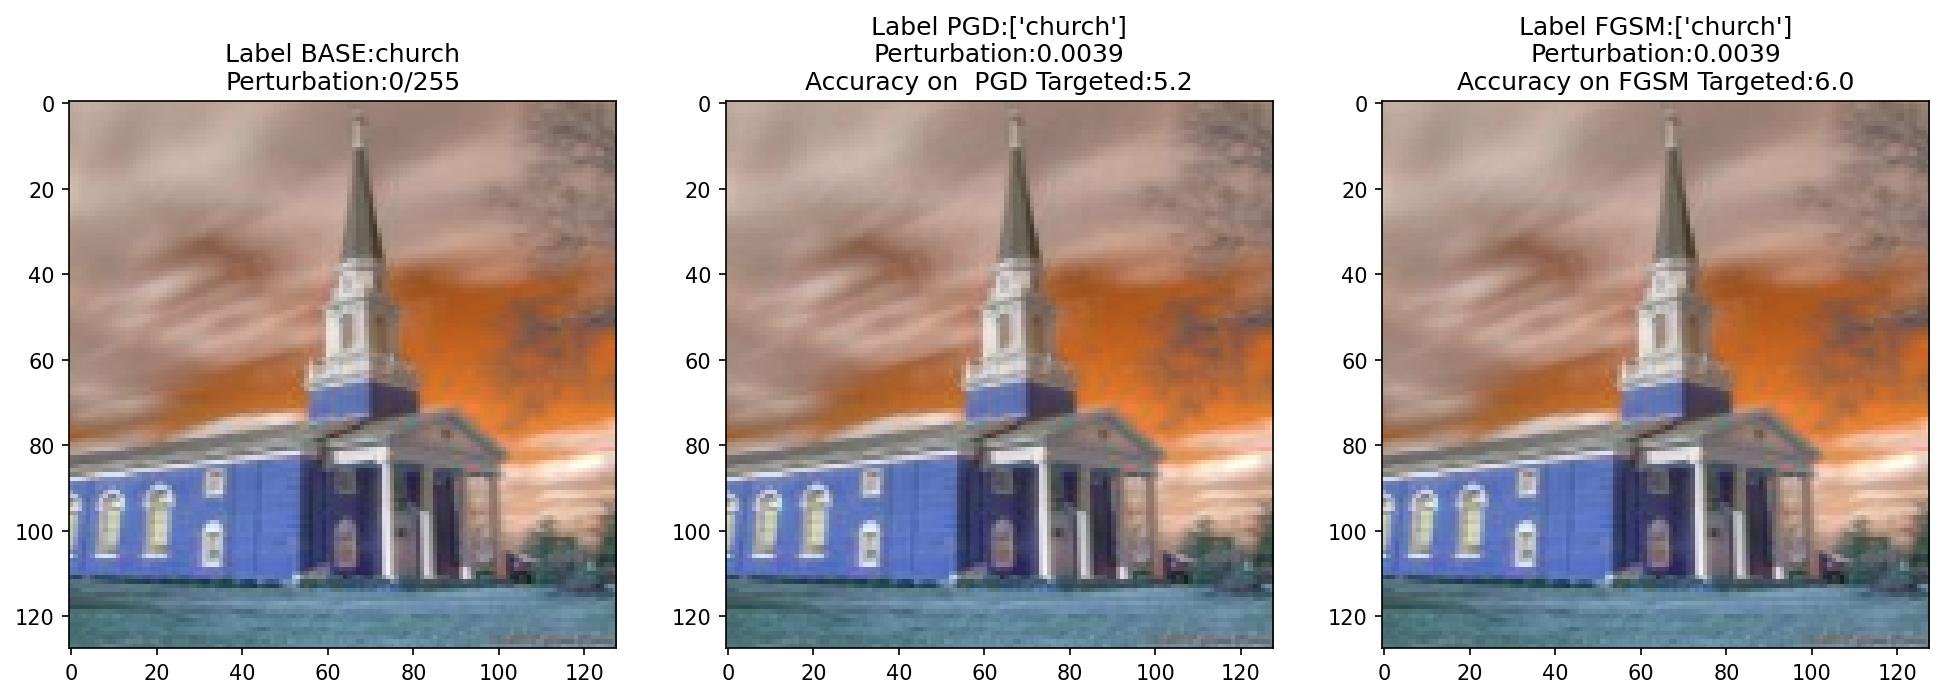

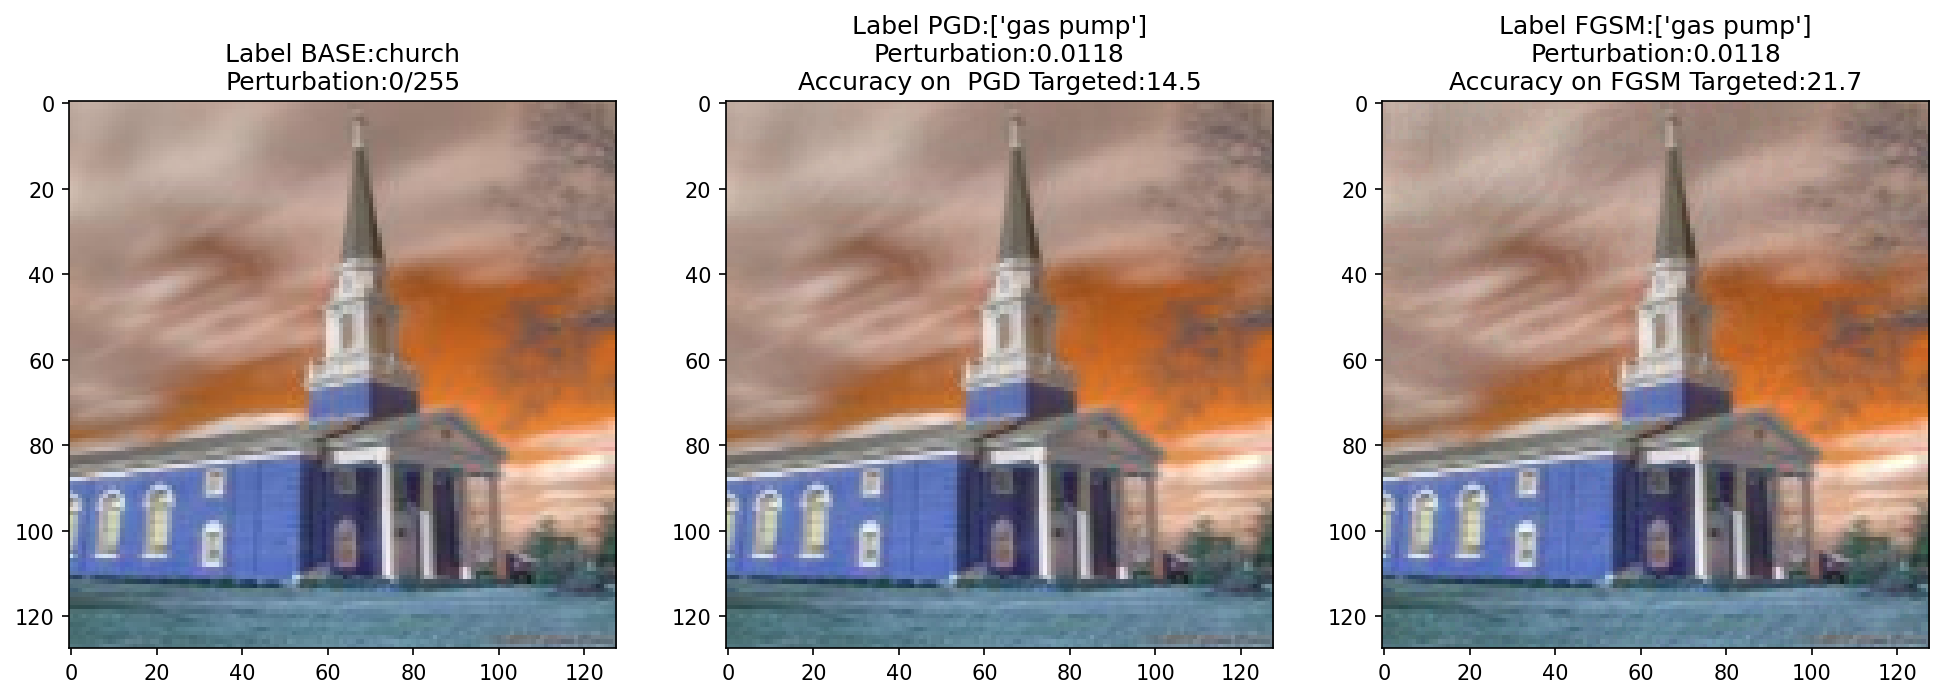

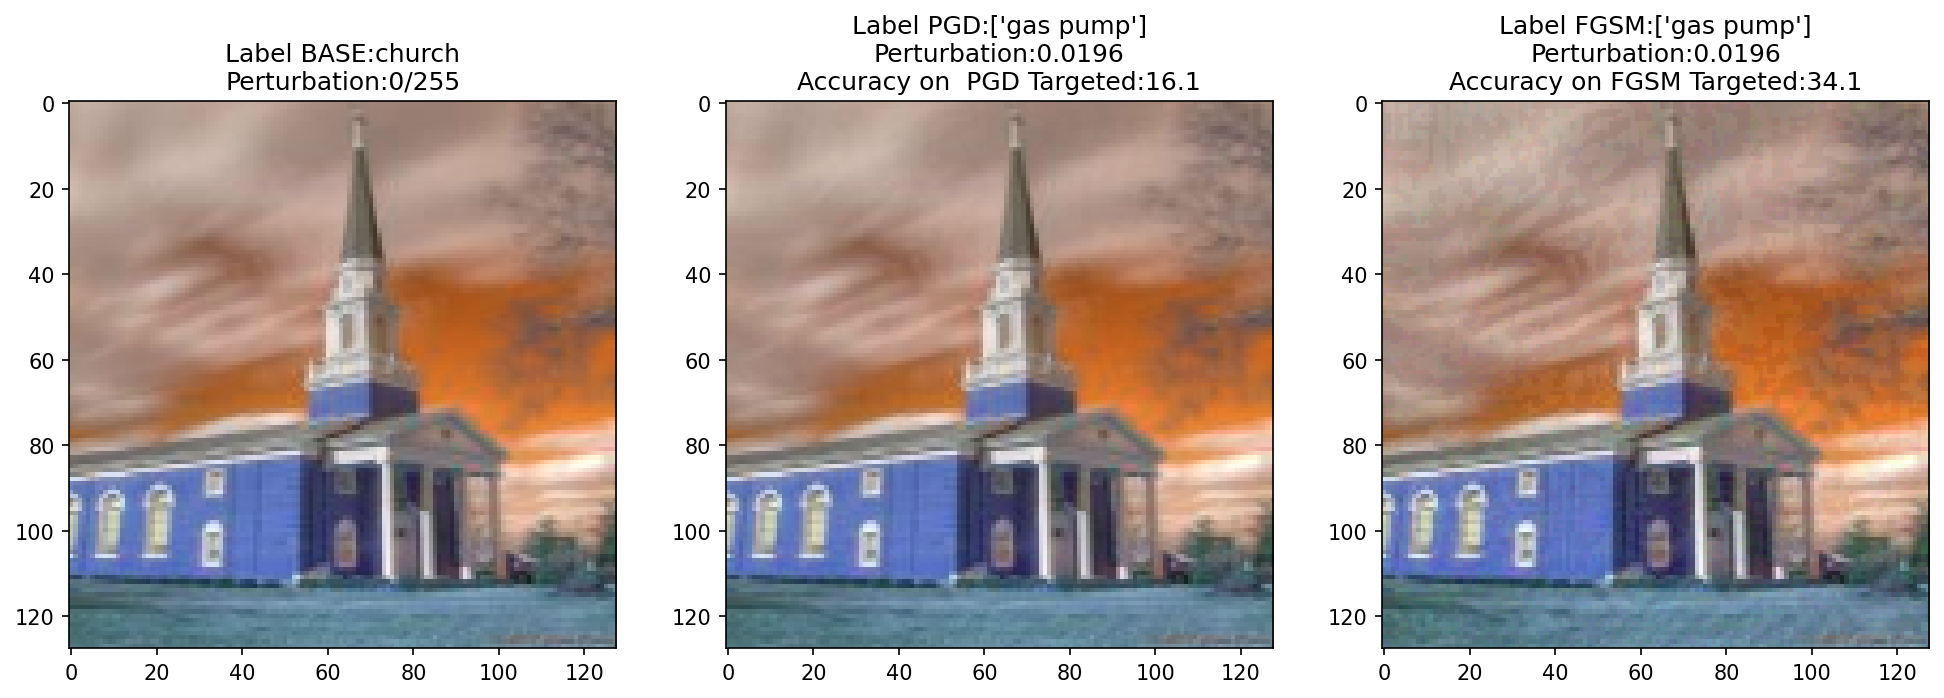

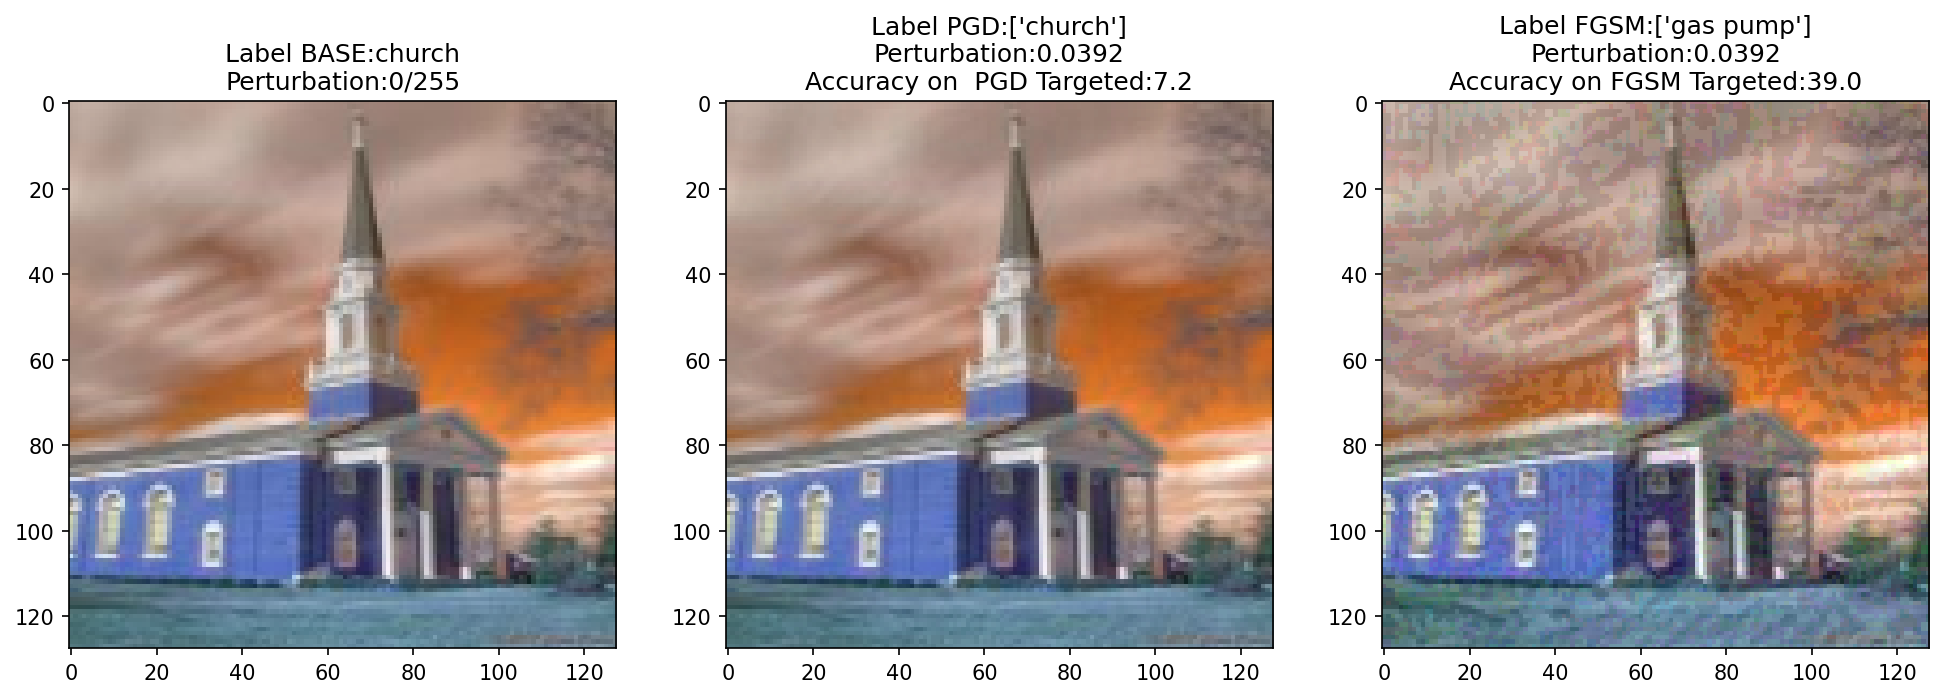

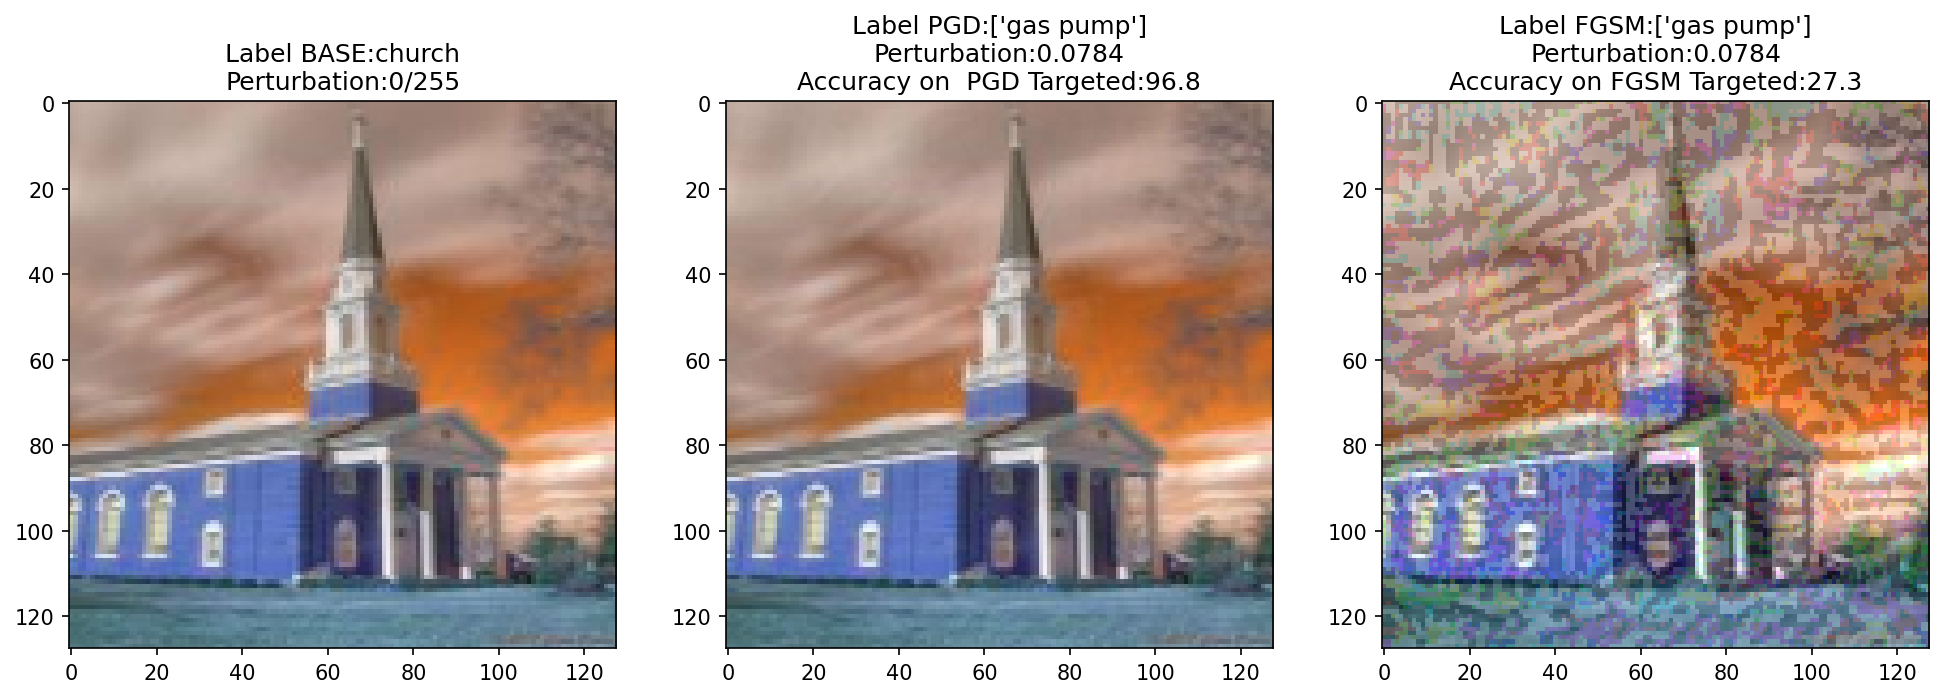

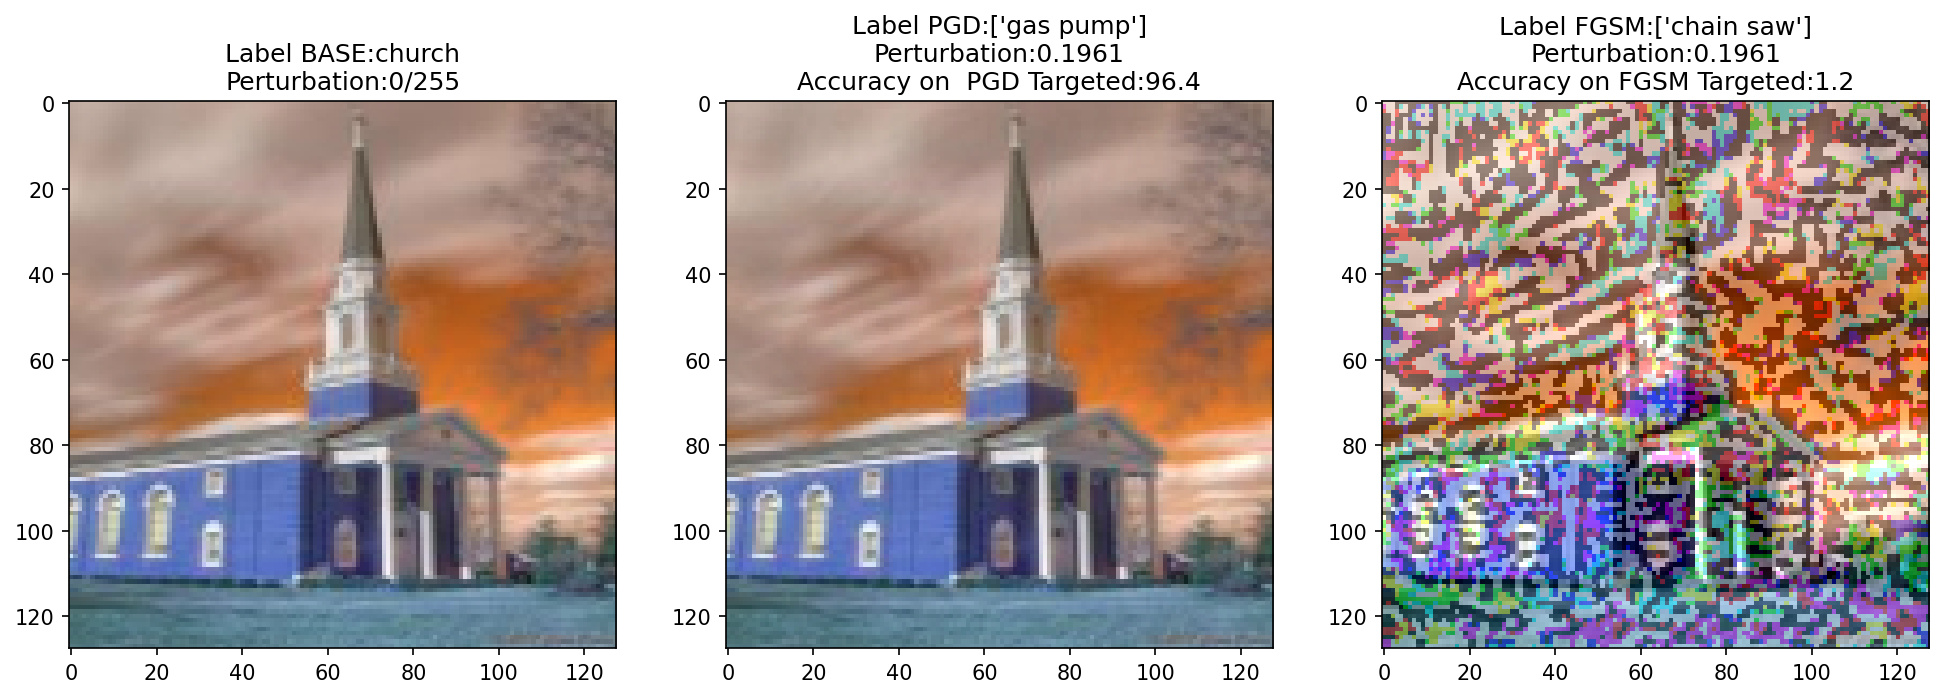

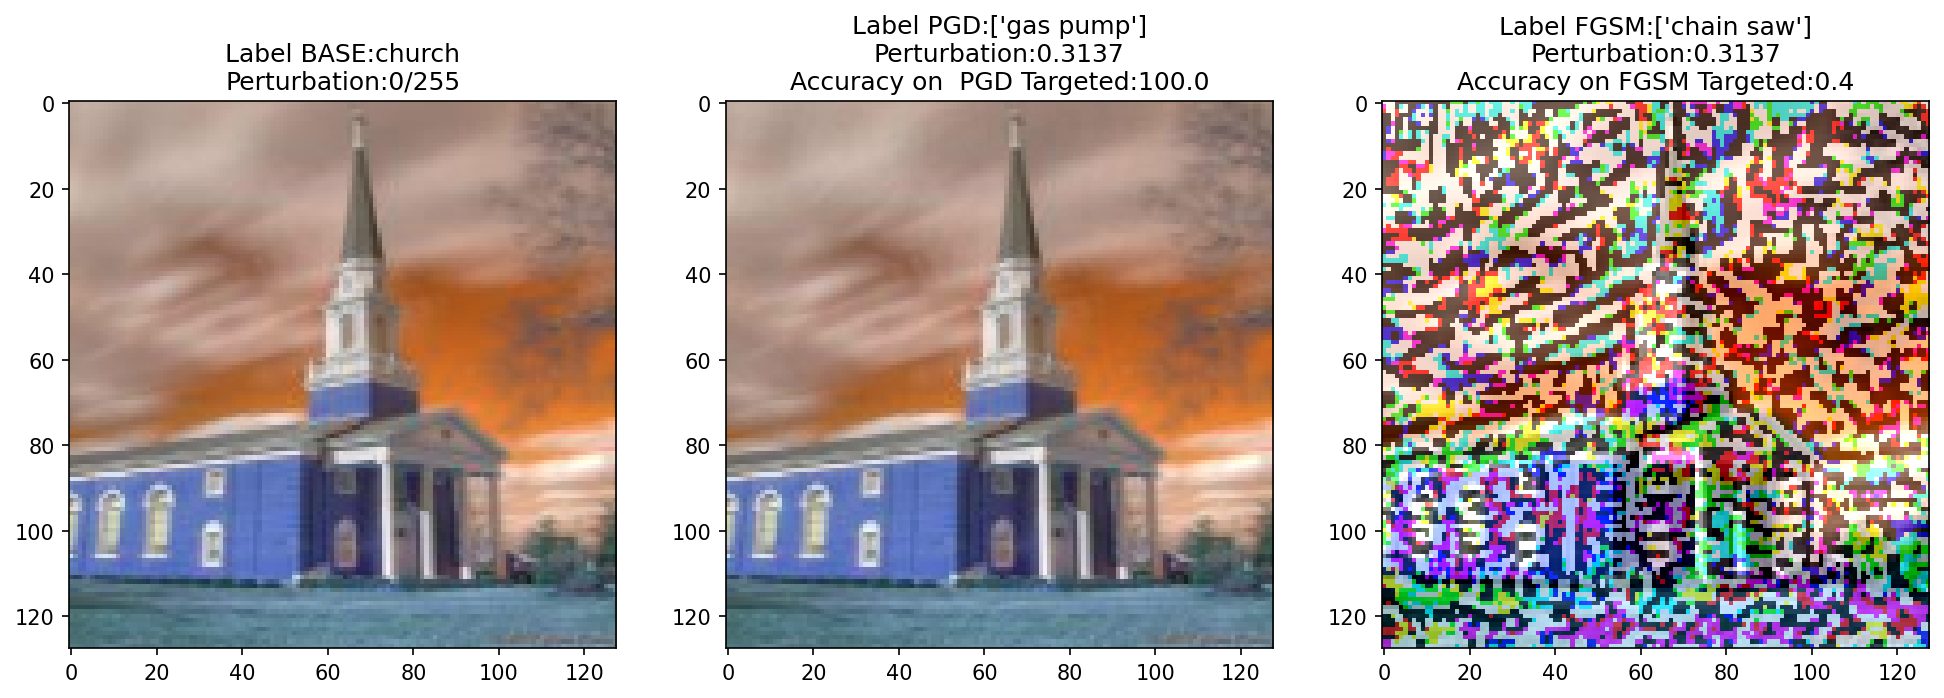

In [18]:
def plot_images(index):
    
    round((pgd_acc_list[i] * 100),1)
    
    plt.figure(figsize=(16, 16), dpi=150)
    #plot unperturbed images
    plt.subplot(1,3,1)
    plt.title('Label BASE:' + str(names[4] + '\n' + 'Perturbation:' + str(0) + '/255'))
    plt.imshow(imgs_church[0])
    #pgd
    plt.subplot(1,3,2)
    plt.title('Label PGD:' + str(names[pgd_pred_list[index]]) + '\n' + 'Perturbation:' + str(round(epsilon_list[index],4)) + 
              '\nAccuracy on  PGD Targeted:' + str(round((pgd_acc_list[i] * 100),1)))
    plt.imshow(image_list_pgd[index])
    #fgsm
    plt.subplot(1,3,3)
    plt.title('Label FGSM:' + str(names[fgsm_pred_list[index]]) + '\n' + 'Perturbation:' + str(round(epsilon_list[index],4)) + 
             '\nAccuracy on FGSM Targeted:' + str(round((fgsm_acc_list[i] * 100),1)))
    plt.imshow(image_list_fgsm[index])
    
    plt.show

    
for i in range(len(epsilon_list)):

    plot_images(i)
    print('Accuracy on adversarial test data PGD Targeted: {:4.2f}%'.format(pgd_acc_list[i] * 100))
    print('Accuracy on adversarial test data FGSM Targeted: {:4.2f}%'.format(fgsm_acc_list[i] * 100))